In [1]:
import os
import numpy as np
import matplotlib.pylab as plt
home_location = os.path.expanduser('~')
desktop_location = os.path.join(home_location, 'Desktop', 'Neuropil_Revision', 'V2')
documents_location = os.path.join(home_location, 'Documents')
data_location = os.path.join('E:\\', 'DATA')
# data-folders per condition
V1_location = os.path.join(home_location, 'Desktop', 'Neuropil_Revision', 'V1')
V2_location = os.path.join(home_location, 'Desktop', 'Neuropil_Revision', 'V2')

In [2]:
# find all TSeries folder

#data_folder = '/Users/fani.koukouli/Desktop/Neuropil_Revision/V1/Mouse2' # folder all the TSeries-... folder
data_folder = os.path.join(os.path.expanduser('~'), 'DATA')
TSeries_folders = [df for df in os.listdir(data_folder) if ('TSeries' in df)]

TSeries_folders = [os.path.join(data_folder, t) for t in TSeries_folders]
print(TSeries_folders)


['/home/yann.zerlaut/DATA/TSeries-191121_278-0005-005', '/home/yann.zerlaut/DATA/TSeries-10262021-1015-002', '/home/yann.zerlaut/DATA/TSeries-191121_278-0002-003', '/home/yann.zerlaut/DATA/TSeries-221121_175-0001-001', '/home/yann.zerlaut/DATA/TSeries-191121_181-0002-002', '/home/yann.zerlaut/DATA/TSeries-10202021-071-004', '/home/yann.zerlaut/DATA/TSeries-191121_278-0004-004', '/home/yann.zerlaut/DATA/TSeries-10202021-285-001', '/home/yann.zerlaut/DATA/TSeries-191121_258-0001-001', '/home/yann.zerlaut/DATA/TSeries-10202021-120-002', '/home/yann.zerlaut/DATA/TSeries-10202021-225-002', '/home/yann.zerlaut/DATA/TSeries-10212021-164-001', '/home/yann.zerlaut/DATA/TSeries-10262021-1015-001', '/home/yann.zerlaut/DATA/TSeries-12232021-1316-006', '/home/yann.zerlaut/DATA/TSeries-221121_114-0001-001', '/home/yann.zerlaut/DATA/TSeries-10212021-089-002']


In [11]:
import numpy as np
from scipy.ndimage import filters

def fill_center_and_edges(N, Window, smv):
    sliding_min = np.zeros(N)
    iw = int(Window/2)+1
    if len(smv.shape)==1:
        sliding_min[:iw] = smv[0]
        sliding_min[-iw:] = smv[-1]
        sliding_min[iw:iw+smv.shape[-1]] = smv
    elif len(smv.shape)==2:
        sliding_min[:,:iw] = np.broadcast_to(smv[:,0], (iw, array.shape[0])).T
        sliding_min[:,-iw:] = np.broadcast_to(smv[:,-1], (iw, array.shape[0])).T
        sliding_min[:,iw:iw+smv.shape[-1]] = smv
    return sliding_min

def compute_sliding_percentile(array, percentile, Window,
                              with_smoothing=True):
    """
    trying numpy code to evaluate efficiently the distrib percentile over a sliding window
    making use of "stride tricks" for fast looping over the sliding window
    
        not really efficient so far... :(
    
    see: 
    https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
    """
    
    # using a sliding "view" of the array
    view = np.lib.stride_tricks.sliding_window_view(array, Window, axis=-1)
    smv = np.percentile(view, percentile, axis=-1)
    # replacing values, N.B. need to deal with edges
    sliding_min = fill_center_and_edges(len(array), Window, smv)
    if with_smoothing:
        return filters.gaussian_filter1d(sliding_min, Window, axis=-1)
    else:
        return sliding_min

def compute_sliding_mean(array, Window):
    """ sliding average by convolution with unit array of length window
    """
    iw = int(Window/2)+1
    return fill_center_and_edges(len(array), Window,
                                 np.convolve(array, np.ones(Window), 'valid')/Window)


def compute_sliding_minmax(array, Window, sig=10):
    #Flow = filters.gaussian_filter1d(array, [0., sig])
    Flow = filters.gaussian_filter1d(array, sig)
    Flow = filters.minimum_filter1d(Flow, Window, mode='wrap')
    Flow = filters.maximum_filter1d(Flow, Window, mode='wrap')
    return Flow
   
    
class Data:
    
    def __init__(self, TSeries_folder,
                 acq_freq=30.25):
        """
        # load data
        - acq_freq in Hz
        """
        # load fluorescence of ROI neuropil (only valid ROIs)
        self.df = TSeries_folder
        F = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'F.npy'))
        Fneu = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'Fneu.npy'))
        iscell = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'iscell.npy'))[:,0].astype(bool)
        # copmute time from acq freq
        self.t, self.acq_freq = np.arange(F.shape[1])/acq_freq, acq_freq
        # focusing only on selected cell
        self.F_ROI = F[iscell,:]
        self.F_neuropil = Fneu[iscell,:]
        self.nROI = self.F_ROI.shape[0]

    def compute_F0(self, F,
                   sliding_minmax_as_F0=True,
                   sliding_mean_as_F0=False,
                   sliding_percentile=5,
                   sliding_window=60):
        if sliding_minmax_as_F0:
            return compute_sliding_minmax(F,
                                           int(sliding_window*self.acq_freq))
        elif sliding_mean_as_F0:
            return compute_sliding_mean(F,
                                        int(sliding_window*self.acq_freq))
        else:
            return compute_sliding_percentile(F, 
                                             sliding_percentile,
                                             int(sliding_window*self.acq_freq))


    def compute_dFoF(self, roi_index=None, 
                     neuropil_correction_factor=0.,
                     sliding_minmax_as_F0=True,
                     sliding_mean_as_F0=False,
                     sliding_percentile=5,
                     sliding_window=60,
                     verbose=True):
        """
        compute fluorescence variation with a neuropil correction set by the factor "neuropil_correction_factor"
        """
        if roi_index is None:
            roi_index = np.arange(self.nROI)
            
        if (neuropil_correction_factor>1) or (neuropil_correction_factor<0):
            print('/!\ neuropil_correction_factor has to be in the interval [0.,1]')
            print('neuropil_correction_factor set to 0 !')
            neuropil_correction_factor=0.
            
        new_F = self.F_ROI[roi_index,:]-neuropil_correction_factor*self.F_neuropil[roi_index,:]

        F0 = self.compute_F0(new_F,
                             sliding_minmax_as_F0=sliding_minmax_as_F0,
                             sliding_mean_as_F0=sliding_mean_as_F0,
                             sliding_percentile=sliding_percentile,
                             sliding_window=sliding_window)
            
        if np.sum(F0<=0)>1:
            if verbose:
                print(' /! \ TOO STRONG NEUROPIL CORRECTION FOR FACTOR = %.2f')
                print('           --> NEGATIVE FLUORESCENCE !!') 
                print('    --> returning zero array') 
            return None, None
        else:
            if type(roi_index) in [list, range, np.array, np.ndarray]:
                return (new_F-F0)/F0, F0
            else:
                return (new_F-F0)/F0, F0
        
    # plot raw data
    def plot_raw(self, roi_index=0, tzoom=None, subsampling=1):
        """
        plot both roi and neuropil fluo for those data
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
        ax.plot(self.t[time_cond][::subsampling], self.F_ROI[roi_index, time_cond][::subsampling], label='ROI')
        ax.plot(self.t[time_cond][::subsampling], self.F_neuropil[roi_index, time_cond][::subsampling], label='neuropil')
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('fluo. (a.u.)')

    # plot raw data with Neuropil correction
    def plot_corrected_raw(self, roi_index=0, tzoom=None, subsampling=1,
                           neuropil_correction_factor=0.,
                           sliding_minmax_as_F0=True,
                           sliding_mean_as_F0=False,
                           sliding_percentile=5,
                           sliding_window=60):
        """
        plot corrected fluo and sliding min
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
        
        new_F = self.F_ROI[roi_index,:]-neuropil_correction_factor*self.F_neuropil[roi_index,:]

        F0 = self.compute_F0(new_F,
                             sliding_minmax_as_F0=sliding_minmax_as_F0,
                             sliding_mean_as_F0=sliding_mean_as_F0,
                             sliding_percentile=sliding_percentile,
                             sliding_window=sliding_window)

        if sliding_minmax_as_F0:
            label='F0 (minmax, T=%is)' % (sliding_window)
        elif sliding_mean_as_F0:
            label='F0 (mean, T=%is)' % (sliding_window)
        else:
            label='F0 (%i%%, T=%is)' % (sliding_percentile, sliding_window)

        ax.plot(self.t[time_cond][::subsampling], new_F[time_cond][::subsampling],
                label='Fneu factor=%.1f' % neuropil_correction_factor)
        ax.plot(self.t[time_cond][::subsampling], F0[time_cond][::subsampling], color=plt.cm.tab10(3),
                lw=3, label=label)
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('corrected fluo. (a.u.)')

    # plot fluorescence variations
    def plot_dFoF(self, 
                  roi_index=0, 
                  neuropil_correction_factor=0.,
                  sliding_minmax_as_F0=True,
                  sliding_mean_as_F0=False,
                  sliding_percentile=5,
                  sliding_window=60,
                  factors=None,
                  tzoom=None, subsampling=1):
        """
        plot both roi and neuropil fluo for those data
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
        
        if factors is None:
            factors = [neuropil_correction_factor]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        for nrp_factor in factors:
            dFoF, F0 = self.compute_dFoF(roi_index=roi_index,
                                         sliding_minmax_as_F0=sliding_minmax_as_F0,
                                         sliding_mean_as_F0=sliding_mean_as_F0, 
                                         sliding_percentile=sliding_percentile,
                                         sliding_window=sliding_window,
                                         neuropil_correction_factor=nrp_factor)
            if dFoF is not None:
                time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
                ax.plot(self.t[time_cond][::subsampling], dFoF[time_cond][::subsampling], 
                    label='Neuropil factor=%.1f' % nrp_factor)
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('dF/F')

    def plot_dFoF_hist(self, 
                       roi_index=0, 
                       neuropil_correction_factor=0.,
                       sliding_minmax_as_F0=True,
                       sliding_mean_as_F0=False,
                       sliding_percentile=5,
                       sliding_window=60,
                       bins=50,
                       factors=None):
        """
        plot dF/F hist
        """
        if factors is None:
            factors = [neuropil_correction_factor]
            
        fig, ax = plt.subplots(figsize=(4,2))
        
        for nrp_factor in factors:
            dFoF,_ = self.compute_dFoF(roi_index=roi_index,
                                       sliding_minmax_as_F0=sliding_minmax_as_F0,
                                       sliding_mean_as_F0=sliding_mean_as_F0, 
                                       sliding_percentile=sliding_percentile,
                                       sliding_window=sliding_window,
                                       neuropil_correction_factor=nrp_factor)
            ax.hist(dFoF, bins=bins, density=True, alpha=.7,
                    label='Fneu factor=%.1f' % nrp_factor)
        ax.legend(fontsize='small')
        ax.set_xlabel('dF/F')
        ax.set_ylabel('n. count')


    def get_mean_sem_dFoF_over_cells(self, 
                                     neuropil_correction_factor=0.,
                                     sliding_minmax_as_F0=True,
                                     sliding_mean_as_F0=False,
                                     sliding_percentile=5,
                                     sliding_window=60,
                                     verbose=True):
        means, stds = [], []
        if verbose:
            print('Datafile: "%s" ' % self.df)
            print(' neuropil-correction-factor=%.2f' % neuropil_correction_factor)
            print('-> running loop over cells [...]')
        for roi in range(self.nROI):
            dFoF, _ = self.compute_dFoF(roi_index=roi,
                                        sliding_minmax_as_F0=sliding_minmax_as_F0,
                                        sliding_mean_as_F0=sliding_mean_as_F0, 
                                        sliding_percentile=sliding_percentile,
                                        sliding_window=sliding_window, 
                                        neuropil_correction_factor=neuropil_correction_factor,
                                        verbose=verbose)
            if dFoF is not None:
                means.append(np.mean(dFoF))
                stds.append(np.std(dFoF))
            else:
                if verbose:
                    print(' - roi #%i is discarded with this neuropil-correction-factor' % roi)
        if verbose:
            print(' -> done ! ')
        return means, stds

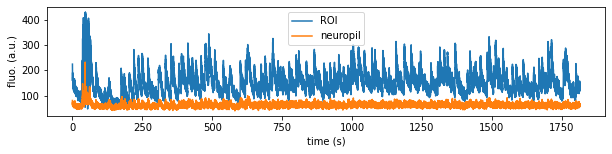

In [12]:
# let's load a datafile and look at the fluorescence
data = Data(TSeries_folders[0])
data.plot_raw(roi_index=10)

## Now relative variation:  $\Delta F$/$F$ = ($F$-$F_0$)/$F_0$

## $F_0$ as a sliding min-max

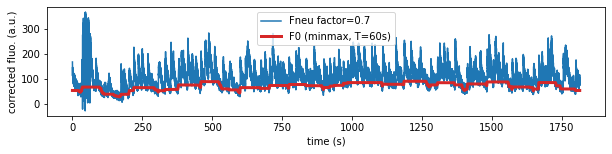

In [13]:
data.plot_corrected_raw(roi_index=10,
                        neuropil_correction_factor=0.7)

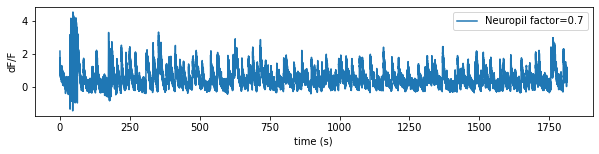

In [14]:
# resulting dF over F
data.plot_dFoF(roi_index=10,
               neuropil_correction_factor=0.7)

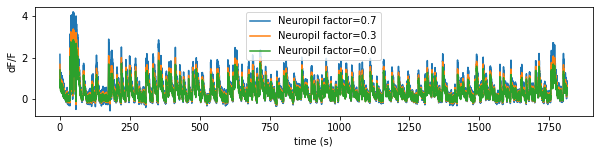

In [15]:
# looking at different dF over F for different correction factors
data.plot_dFoF(roi_index=10,
               factors=[0.7, 0.35, 0], subsampling=5)

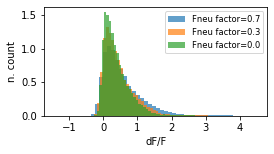

In [16]:
# histogram for that cell
data.plot_dFoF_hist(roi_index=10,
                    factors=[0.7, 0.35, 0])

## $F_0$ as a sliding percentile (<10%, e.g. 5%, i.e. close to a sliding minimum)

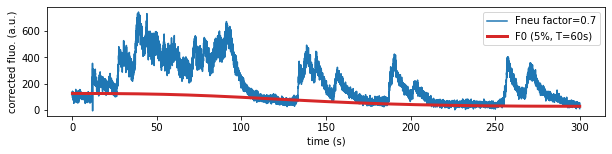

In [70]:
data.plot_corrected_raw(roi_index=10, 
                        sliding_percentile=5,
                        neuropil_correction_factor=0.7)

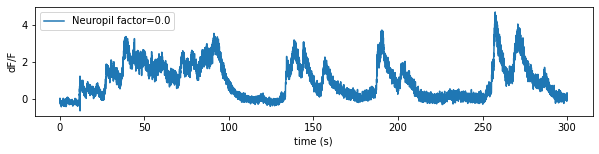

In [71]:
# resulting dF over F
data.plot_dFoF(roi_index=10,
               sliding_percentile=5,
               neuropil_correction_factor=0.)

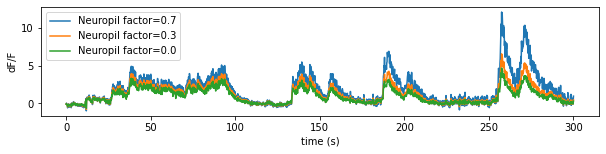

In [72]:
# looking at different dF over F for different correction factors
data.plot_dFoF(roi_index=10, 
               sliding_percentile=5,
               factors=[0.7, 0.35, 0], subsampling=5)

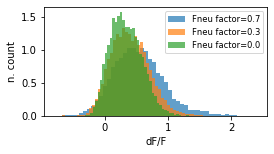

In [74]:

# histogram for that cell
data.plot_dFoF_hist(roi_index=1,
                    sliding_percentile=5,
                    factors=[0.7, 0.35, 0])

In [ ]:
data.plot_corrected_raw(roi_index=10, 
                        sliding_minmax_as_F0=True,
                        neuropil_correction_factor=0.7)

## Session average for the different cells

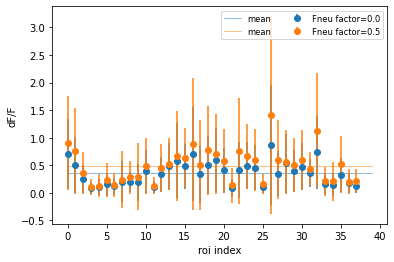

In [17]:
# mean and std for each cell

def plot_session_average(data, CORRECTION_FACTORS, verbose=False):
    fig, ax = plt.subplots()
    for i, factor in enumerate(CORRECTION_FACTORS):
        means, stds = data.get_mean_sem_dFoF_over_cells(neuropil_correction_factor=factor, 
                                                        verbose=verbose)
        ax.errorbar(np.arange(len(means)), means, yerr=stds, fmt='o',
                    label='Fneu factor=%.1f' % factor, color=plt.cm.tab10(i))
        ax.plot([0,len(means)+1], np.mean(means)*np.ones(2), 
                lw=0.5, label='mean', color=plt.cm.tab10(i))
    ax.legend(fontsize='small', ncol=2)
    ax.set_xlabel('roi index')
    ax.set_ylabel('dF/F')
    return fig, ax

fig, ax = plot_session_average(data, [0, 0.5])

Datafile: "/home/yann.zerlaut/DATA/TSeries-191121_278-0005-005" 
 neuropil-correction-factor=0.00
-> running loop over cells [...]
 -> done ! 
Datafile: "/home/yann.zerlaut/DATA/TSeries-191121_278-0005-005" 
 neuropil-correction-factor=0.35
-> running loop over cells [...]
 -> done ! 
Datafile: "/home/yann.zerlaut/DATA/TSeries-191121_278-0005-005" 
 neuropil-correction-factor=0.70
-> running loop over cells [...]
 -> done ! 
Datafile: "/home/yann.zerlaut/DATA/TSeries-10262021-1015-002" 
 neuropil-correction-factor=0.00
-> running loop over cells [...]
 -> done ! 
Datafile: "/home/yann.zerlaut/DATA/TSeries-10262021-1015-002" 
 neuropil-correction-factor=0.35
-> running loop over cells [...]
 -> done ! 
Datafile: "/home/yann.zerlaut/DATA/TSeries-10262021-1015-002" 
 neuropil-correction-factor=0.70
-> running loop over cells [...]
 /! \ TOO STRONG NEUROPIL CORRECTION FOR FACTOR = %.2f
           --> NEGATIVE FLUORESCENCE !!
    --> returning zero array
 - roi #5 is discarded with this neu

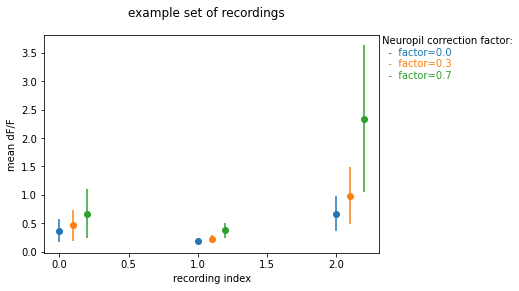

In [18]:


def loop_over_folder_list(folder_list,
                          CORRECTION_FACTORS = [0, 0.35, 0.7],
                          with_fig=True, title=''):
    # mean and std for each cell
    if with_fig:
        fig, ax = plt.subplots()
        fig.suptitle(title)
        
    MEAN_PER_RECORDING = {}
    for factor in CORRECTION_FACTORS:
        MEAN_PER_RECORDING[str(factor)] = []

    for t, df in enumerate(folder_list):
        try:
            data = Data(df)
            for i, factor in enumerate(CORRECTION_FACTORS):
                means = data.get_mean_sem_dFoF_over_cells(neuropil_correction_factor=factor,
                                                              verbose=True)
                if with_fig:
                    ax.errorbar([t+.1*i], [np.mean(means)], yerr=[np.std(means)], fmt='o',
                                color=plt.cm.tab10(i))
                MEAN_PER_RECORDING[str(factor)].append(np.mean(means))
        except BaseException as be:
            print(be)
            print(' /!\ "%s" INVALID DATAFOLDER  ' % df)

    if with_fig:
        ax.annotate(' Neuropil correction factor:', (1,1), xycoords='axes fraction', va='top')
        for i, factor in enumerate(CORRECTION_FACTORS):
            ax.annotate((i+1)*'\n'+'   -  factor=%.1f' % factor, (1,1), 
                        xycoords='axes fraction', color=plt.cm.tab10(i), va='top')
        ax.set_xlabel('recording index')
        ax.set_ylabel('mean dF/F')                                   
    else:
        fig = None
        
    return MEAN_PER_RECORDING, fig
                      
MEAN_PER_RECORDING, fig = loop_over_folder_list(TSeries_folders[:3],
                                                CORRECTION_FACTORS = [0, 0.35, 0.7],
                                                title='example set of recordings')
# fig.savefig('fig.png')

In [19]:
print(MEAN_PER_RECORDING['0'])

[0.3699611, 0.18643647, 0.6689553]


In [20]:
print(MEAN_PER_RECORDING['0.7'])

[0.66881657, 0.37681857, 2.336042]


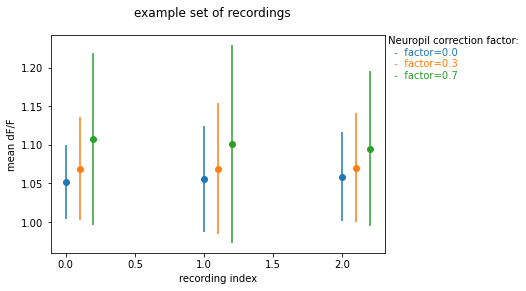

In [51]:

CORRECTION_FACTORS = [0, 0.35, 0.7]

def loop_over_folder_list(folder_list,
                          CORRECTION_FACTORS = [0, 0.35, 0.7],
                          with_fig=True, title=''):
    # mean and std for each cell
    if with_fig:
        fig, ax = plt.subplots()
        fig.suptitle(title)
        
    MEAN_PER_RECORDING = {}
    for factor in CORRECTION_FACTORS:
        MEAN_PER_RECORDING[str(factor)] = []

    for t, df in enumerate(folder_list):
        try:
            data = Data(df)
            for i, factor in enumerate(CORRECTION_FACTORS):
                mean, std = data.get_mean_sem_dFoF_over_cells_safe(neuropil_correction_factor=factor,
                                                                  verbose=False)
                if with_fig:
                    ax.errorbar([t+.1*i], [mean], yerr=[std], fmt='o',
                                color=plt.cm.tab10(i))
                MEAN_PER_RECORDING[str(factor)].append(mean)
        except BaseException as be:
            print(be)
            print(' /!\ "%s" INVALID DATAFOLDER  ' % df)

    if with_fig:
        ax.annotate(' Neuropil correction factor:', (1,1), xycoords='axes fraction', va='top')
        for i, factor in enumerate(CORRECTION_FACTORS):
            ax.annotate((i+1)*'\n'+'   -  factor=%.1f' % factor, (1,1), 
                        xycoords='axes fraction', color=plt.cm.tab10(i), va='top')
        ax.set_xlabel('recording index')
        ax.set_ylabel('mean dF/F')                                   
    else:
        fig = None
        
    return MEAN_PER_RECORDING, fig
                      
MEAN_PER_RECORDING, fig = loop_over_folder_list(TSeries_folders[:3], title='example set of recordings')
fig.savefig('fig.png')


currently running Mouse2 in V1  [...]
currently running Mouse2 in V2  [...]


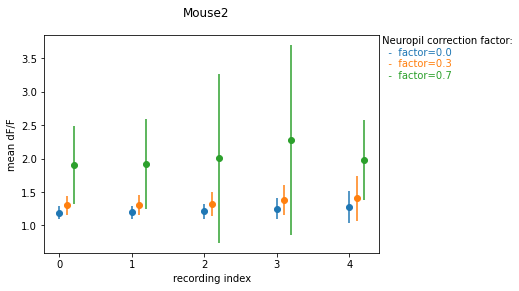

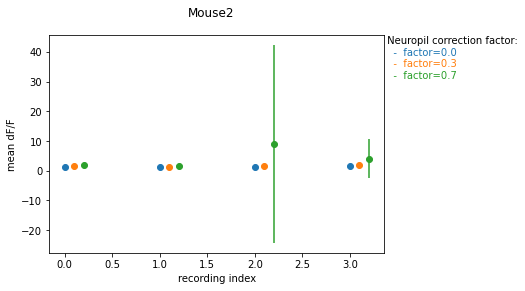

In [40]:
DATA = {}
for condition, location in zip(['V1', 'V2'], 
                               [V1_location, V2_location]):
    DATA[condition] = []
    Mice_directories = [f for f in os.listdir(location) if os.path.isdir(os.path.join(location, f))]
    for mouse in Mice_directories:
        print('currently running', mouse, 'in', condition, ' [...]')
        TSeries_folders = [os.path.join(location, mouse, f) for f in os.listdir(os.path.join(location, mouse))]
        MEAN_PER_RECORDING, fig = loop_over_folder_list(TSeries_folders,
                                                        title=condition+' -- '+mouse)
        DATA[condition].append(MEAN_PER_RECORDING)

NameError: name 'DATA' is not defined

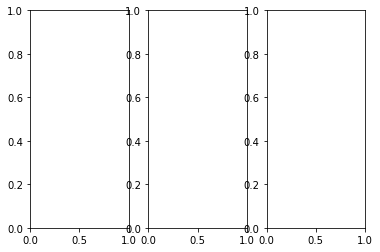

In [26]:
fig, [ax0, ax035, ax07] = plt.subplots(1, 3)

for mouse_id in range(len(DATA['V1'])):
    
    ax0.plot([0], [np.mean(DATA['V1'][mouse_id]['0'])], 'o')
    ax0.plot([1], [np.mean(DATA['V2'][mouse_id]['0'])], 'o')
    
    ax035.plot([0], [np.mean(DATA['V1'][mouse_id]['0.35'])], 'o')
    ax035.plot([1], [np.mean(DATA['V2'][mouse_id]['0.35'])], 'o')

    ax07.plot([0], [np.mean(DATA['V1'][mouse_id]['0.7'])], 'o')
    ax07.plot([1], [np.mean(DATA['V2'][mouse_id]['0.7'])], 'o')
    
#fig.savefig('data_summary.png')  

In [ ]:
DATA['V2'][0]

In [ ]:
DATA['V2'][1]